# Data Preparation

In [6]:
%load_ext autoreload

In [32]:
%autoreload 2
import os
import numpy as np
from typing import Tuple, Dict, List
from tqdm import tqdm
import random

import torch
import torch.nn as nn
from torch.nn import DataParallel
from torch.optim import Adam, Optimizer

from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import matplotlib.pyplot as plt

from train_utils.imagenette_dataset import ImageNetteDataset, train_val_split
from train_utils.trainer import train
from models.ResNet import resnet, resnext
from train_utils.utils import get_random_images, plot_predictions, plot_confusion_matrix

In [17]:
BATCH_SIZE = 256
N_WORKERS = 8
DEVICE_IDS = [4, 5, 6, 7]
N_EPOCHS = 75
LR = 5*1e-3

In [ ]:
def download_data():
    if not os.path.exists('data'):
        os.mkdir('data')

    if not os.listdir('data'):
        !wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
        !tar -xzvf 'imagenette2.tgz' -C 'data'

download_data()

In [12]:
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=4)

In [13]:
train_dataset, val_dataset = train_val_split(
    ImageNetteDataset(root_dir='data/imagenette2/train'), 
    val_size=0.2)
test_dataset = ImageNetteDataset(root_dir='data/imagenette2/val')

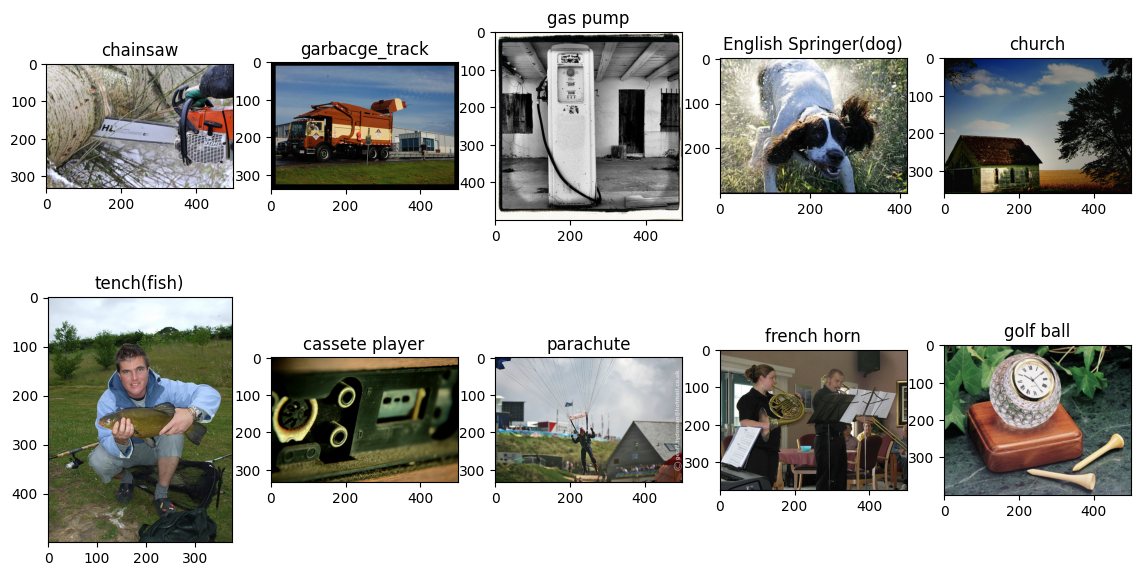

In [14]:
train_dataset.dataset.random_data_examples()

In [15]:
print(f'Train size = {len(train_dataset)}, Validation size = {len(val_dataset)}, Test size = {len(test_dataset)}')

Train size = 7575, Validation size = 1894, Test size = 3925


In [12]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)

# Torchvision's and mine models comparison

In [2]:
!pip install torchinfo
from torchinfo import summary


[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [3]:
from torchvision.models import resnet18, resnet50, resnext50_32x4d

## resnet 18

In [19]:
summary(resnet(num_layers=18, use_se=False), (1, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
ResNet                                        [1, 10]                   --
├─Sequential: 1-1                             [1, 64, 56, 56]           --
│    └─Sequential: 2-1                        [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                       [1, 64, 112, 112]         9,408
│    │    └─MaxPool2d: 3-2                    [1, 64, 56, 56]           --
│    │    └─BatchNorm2d: 3-3                  [1, 64, 56, 56]           128
│    │    └─ReLU: 3-4                         [1, 64, 56, 56]           --
├─Sequential: 1-2                             [1, 64, 56, 56]           --
│    └─ResBlock: 2-2                          [1, 64, 56, 56]           --
│    │    └─Sequential: 3-5                   [1, 64, 56, 56]           36,992
│    │    └─Sequential: 3-6                   [1, 64, 56, 56]           36,992
│    │    └─Identity: 3-7                     [1, 64, 56, 56]           --
│    │  

In [20]:
summary(resnet18(num_classes=10), (1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│

## resnet 50

In [33]:
summary(resnet(num_layers=50, use_se=False), (1, 3, 224, 224), depth=4)

Layer (type:depth-idx)                        Output Shape              Param #
ResNet                                        [1, 10]                   --
├─Sequential: 1-1                             [1, 64, 56, 56]           --
│    └─Sequential: 2-1                        [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                       [1, 64, 112, 112]         9,408
│    │    └─BatchNorm2d: 3-2                  [1, 64, 112, 112]         128
│    │    └─ReLU: 3-3                         [1, 64, 112, 112]         --
│    │    └─MaxPool2d: 3-4                    [1, 64, 56, 56]           --
├─Sequential: 1-2                             [1, 256, 56, 56]          --
│    └─BottleNeckBlock: 2-2                   [1, 256, 56, 56]          --
│    │    └─Sequential: 3-5                   [1, 64, 56, 56]           --
│    │    │    └─Conv2d: 4-1                  [1, 64, 56, 56]           4,096
│    │    │    └─BatchNorm2d: 4-2             [1, 64, 56, 56]           128
│    │    │ 

In [29]:
summary(resnet50(num_classes=10), (1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3                    [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-4                  [1, 64, 56, 56]           36,864
│    │    └─BatchNorm2d: 3-5             [1, 64, 56, 56]           128
│    │    └─ReLU: 3-6                    [1, 64, 56, 56]           --
│ 

## resnext 50 cardinality=32 width=4

In [35]:
summary(resnext(num_layers=50, cardinality=32, width=4, use_se=False), (1, 3, 224, 224), depth=4)

Layer (type:depth-idx)                        Output Shape              Param #
ResNet                                        [1, 10]                   --
├─Sequential: 1-1                             [1, 64, 56, 56]           --
│    └─Sequential: 2-1                        [1, 64, 56, 56]           --
│    │    └─Conv2d: 3-1                       [1, 64, 112, 112]         9,408
│    │    └─BatchNorm2d: 3-2                  [1, 64, 112, 112]         128
│    │    └─ReLU: 3-3                         [1, 64, 112, 112]         --
│    │    └─MaxPool2d: 3-4                    [1, 64, 56, 56]           --
├─Sequential: 1-2                             [1, 256, 56, 56]          --
│    └─BottleNeckBlock: 2-2                   [1, 256, 56, 56]          --
│    │    └─Sequential: 3-5                   [1, 128, 56, 56]          --
│    │    │    └─Conv2d: 4-1                  [1, 128, 56, 56]          8,192
│    │    │    └─BatchNorm2d: 4-2             [1, 128, 56, 56]          256
│    │    │ 

In [31]:
summary(resnext50_32x4d(num_classes=10), (1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 10]                   --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 128, 56, 56]          8,192
│    │    └─BatchNorm2d: 3-2             [1, 128, 56, 56]          256
│    │    └─ReLU: 3-3                    [1, 128, 56, 56]          --
│    │    └─Conv2d: 3-4                  [1, 128, 56, 56]          4,608
│    │    └─BatchNorm2d: 3-5             [1, 128, 56, 56]          256
│    │    └─ReLU: 3-6                    [1, 128, 56, 56]          --
│  

# Training

## Standard resnet models

In [9]:
criterion = nn.CrossEntropyLoss()

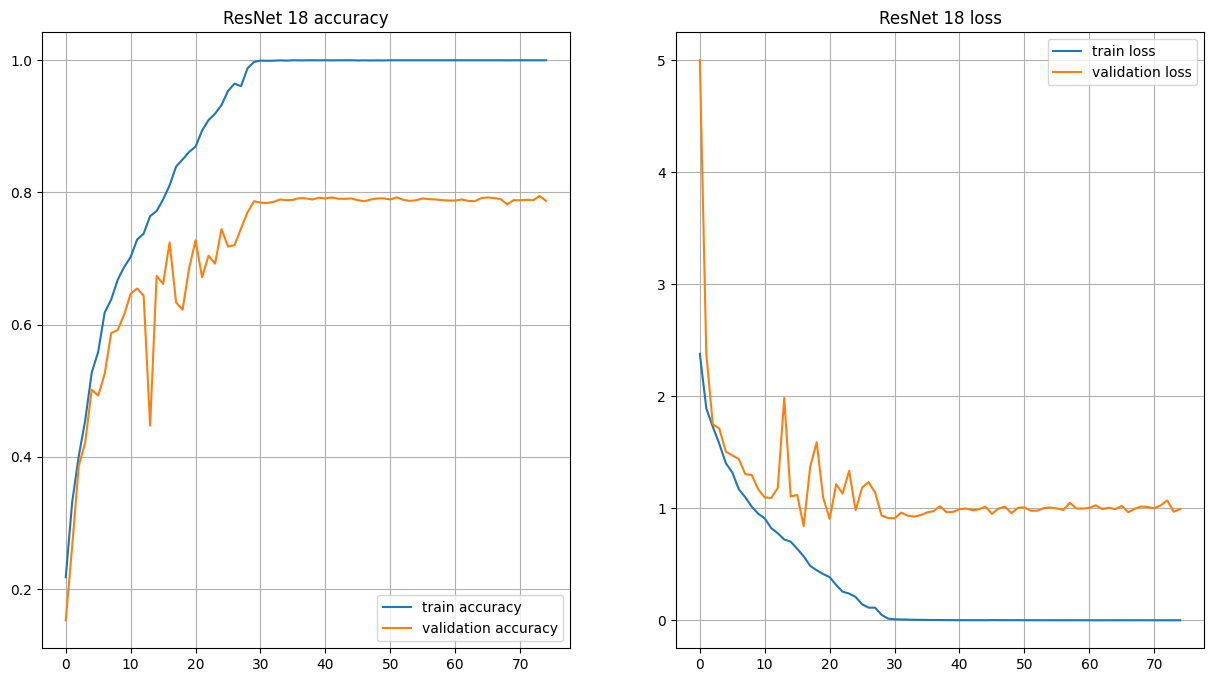

Validation accuracy: 0.787, best_val_acc: 0.795


Testing: 100%|██████████| 16/16 [00:04<00:00,  3.33it/s, accuracy=0.799]


Test accuracy of ResNet 18 = 0.7987261146496816


In [12]:
resnet_18 = DataParallel(resnet(num_layers=18, use_se = False).to(device), device_ids=DEVICE_IDS)
optimizer = Adam(resnet_18.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5)
result_resnet_18 = train(
    resnet_18, 
    train_dataloader, 
    val_dataloader,
    test_dataloader,
    optimizer, 
    criterion, 
    device,
    scheduler, 
    N_EPOCHS, 
    title='ResNet 18')
del resnet_18

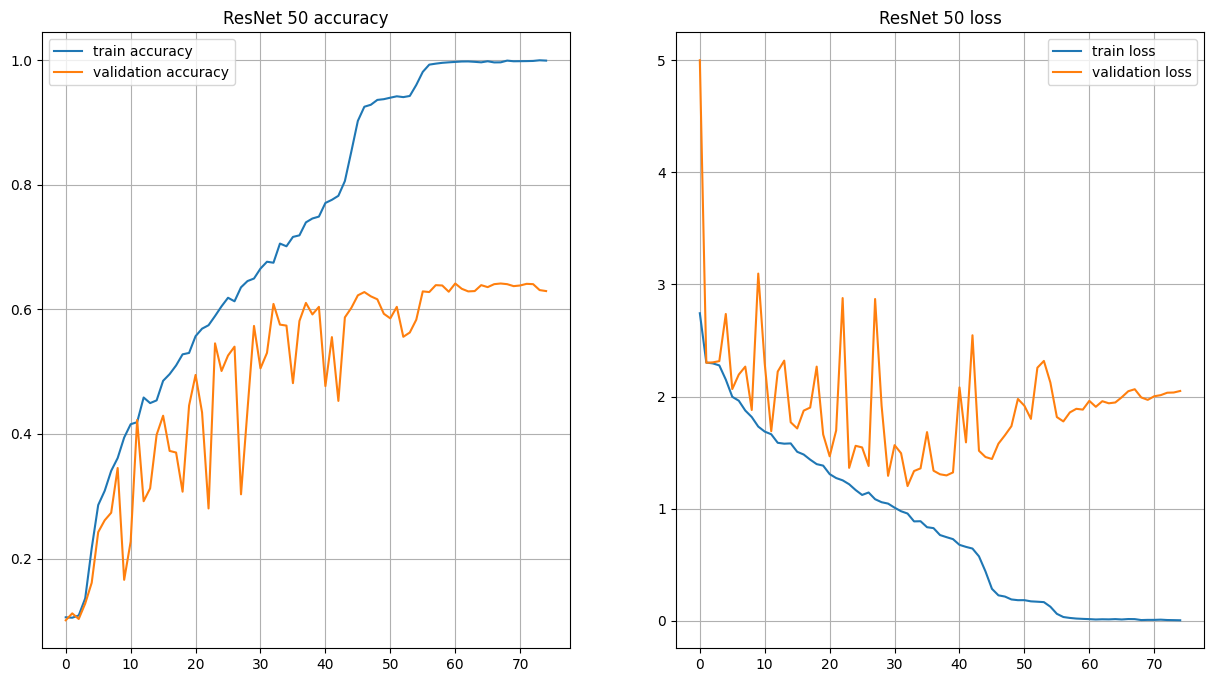

Validation accuracy: 0.629, best_val_acc: 0.641


Testing: 100%|██████████| 16/16 [00:04<00:00,  3.21it/s, accuracy=0.641]

Test accuracy of ResNet 50 = 0.640764331210191


In [15]:
resnet_50 = DataParallel(resnet(num_layers=50, use_se = False).to(device), device_ids=DEVICE_IDS)
optimizer = Adam(resnet_50.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5)
result_resnet_50 = train(
    resnet_50, 
    train_dataloader, 
    val_dataloader,
    test_dataloader,
    optimizer, 
    criterion, 
    device,
    scheduler, 
    N_EPOCHS, 
    title='ResNet 50'
)
del resnet_50

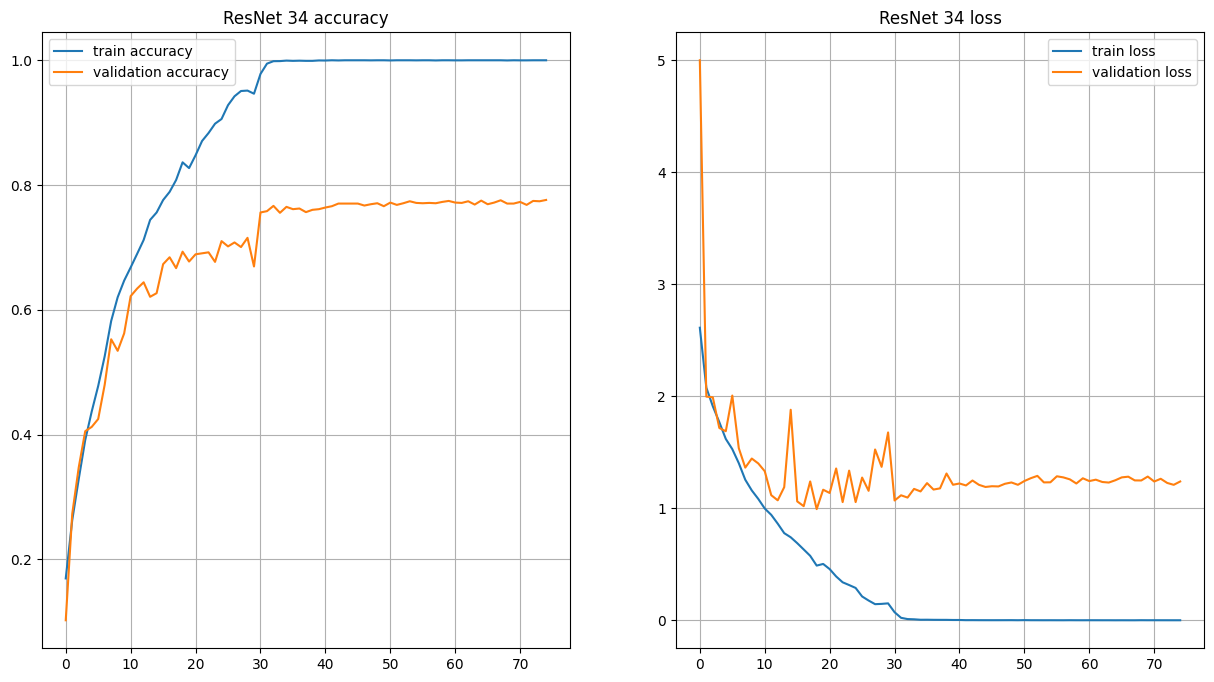

Validation accuracy: 0.776, best_val_acc: 0.776


Testing: 100%|██████████| 16/16 [00:04<00:00,  3.43it/s, accuracy=0.776]


Test accuracy of ResNet 34 = 0.7760509554140127


In [16]:
resnet_34 = DataParallel(resnet(num_layers=34, use_se = False).to(device), device_ids=DEVICE_IDS)
optimizer = Adam(resnet_34.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5)
result_resnet_34 = train(
    resnet_34, 
    train_dataloader, 
    val_dataloader,
    test_dataloader,
    optimizer, 
    criterion, 
    device,
    scheduler, 
    N_EPOCHS, 
    title='ResNet 34'
)
del resnet_34

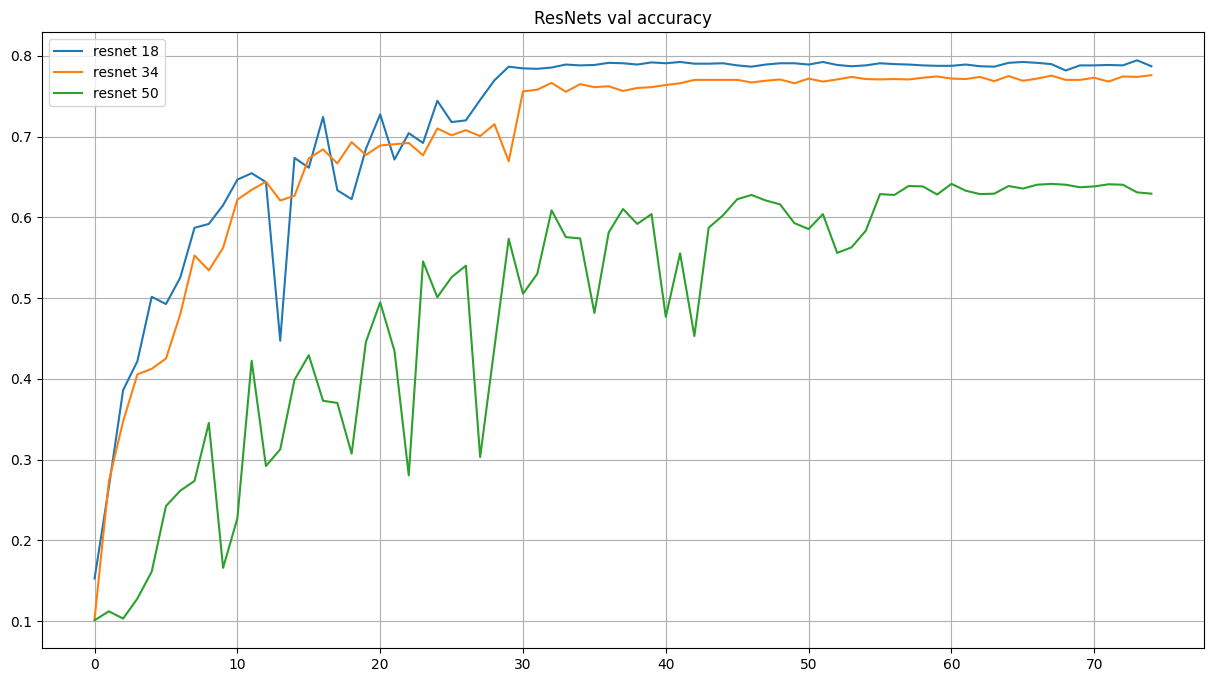

In [17]:
plt.plot(range(N_EPOCHS), result_resnet_18['val_acc'], label='resnet 18')
plt.plot(range(N_EPOCHS), result_resnet_34['val_acc'], label='resnet 34')
plt.plot(range(N_EPOCHS), result_resnet_50['val_acc'], label='resnet 50')
plt.title(label='ResNets val accuracy')
plt.grid()
plt.legend()
plt.show()

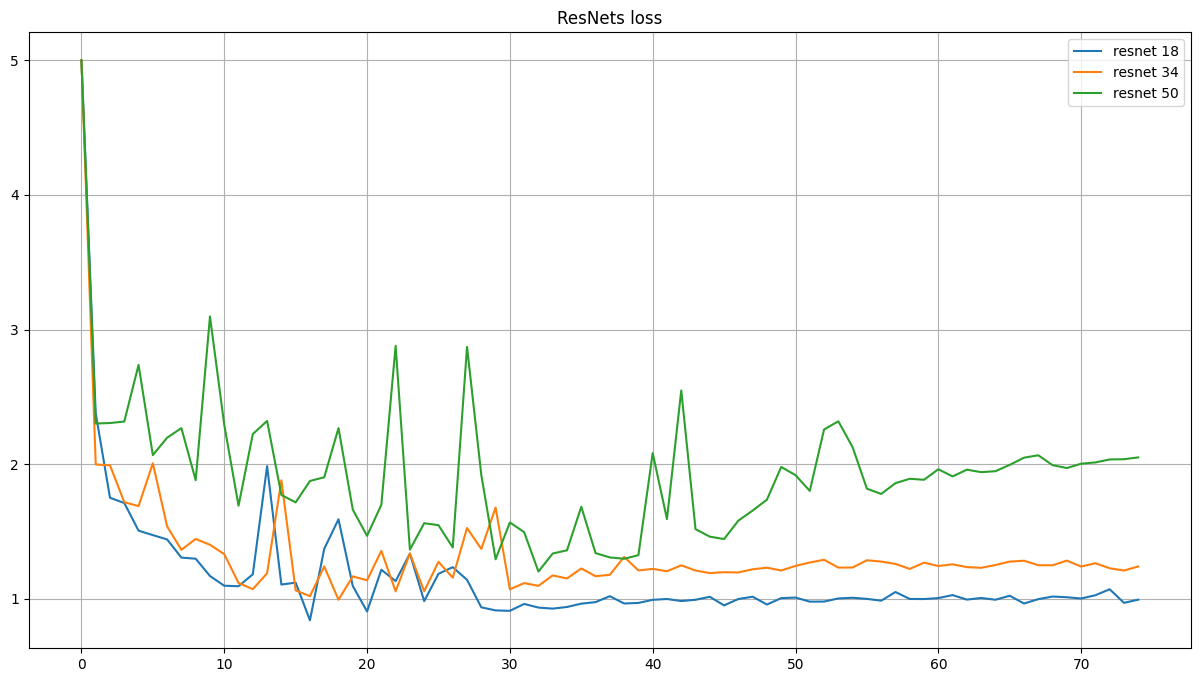

In [18]:
plt.plot(range(N_EPOCHS), result_resnet_18['val_loss'], label='resnet 18')
plt.plot(range(N_EPOCHS), result_resnet_34['val_loss'], label='resnet 34')
plt.plot(range(N_EPOCHS), result_resnet_50['val_loss'], label='resnet 50')
plt.title(label='ResNets loss')
plt.grid()
plt.legend()
plt.show()

In [19]:
test_acc_18 = result_resnet_18['test_acc']
test_acc_34 = result_resnet_34['test_acc']
test_acc_50 = result_resnet_50['test_acc']
print(f'Test accuracies \nResNet 18: {test_acc_18} \
    \nResNet 34: {test_acc_34} \
    \nResNet 50: {test_acc_50}')

Test accuracies 
ResNet 18: 0.7987261146496816     
ResNet 34: 0.7760509554140127     
ResNet 50: 0.640764331210191


In [20]:
torch.save(result_resnet_18['best_state'], 'resnet18.pt')
torch.save(result_resnet_34['best_state'], 'resnet34.pt')
torch.save(result_resnet_50['best_state'], 'resnet50.pt')

## ResNet with c and d + se

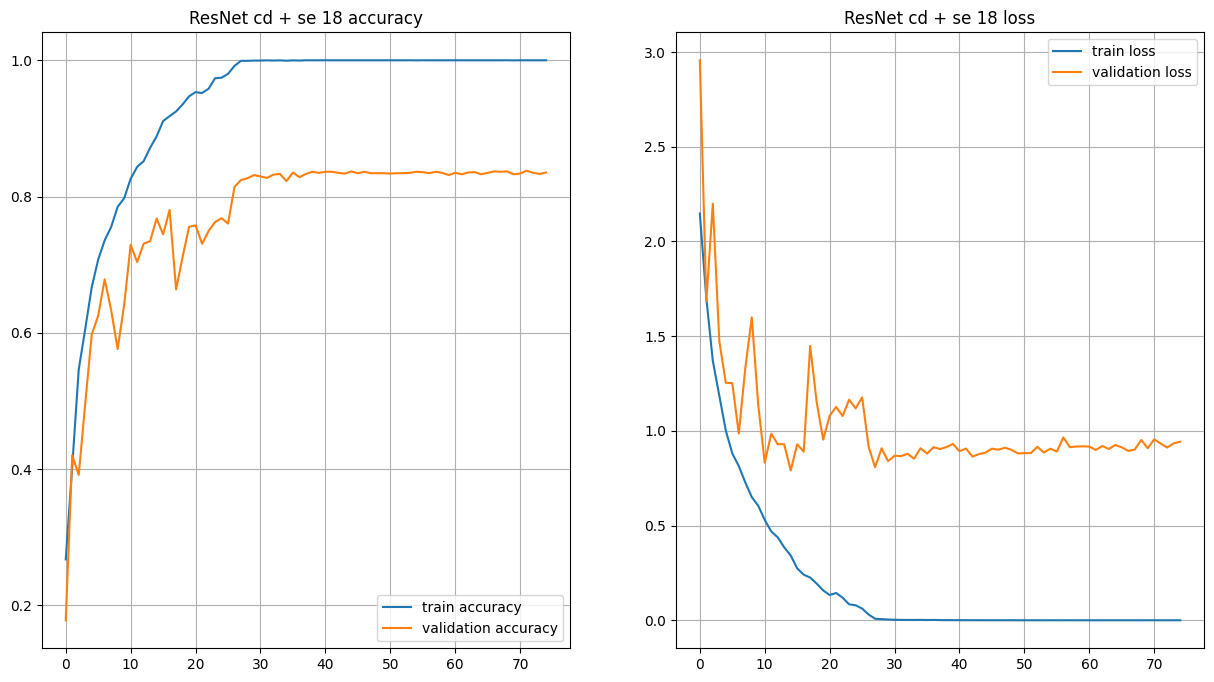

Validation accuracy: 0.835, best_val_acc: 0.838


Testing: 100%|██████████| 16/16 [00:04<00:00,  3.35it/s, accuracy=0.841]

Test accuracy of ResNet cd + se 18 = 0.8407643312101911


In [26]:
resnet_cd_se_18 = DataParallel(
    resnet(num_layers=18,
           use_resnet_c = True,
           use_resnet_d = True,
           use_se = True).to(device), 
    device_ids=DEVICE_IDS
)
optimizer = Adam(resnet_cd_se_18.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5)
result_resnet_18_cd_se = train(
    resnet_cd_se_18, 
    train_dataloader, 
    val_dataloader,
    test_dataloader,
    optimizer, 
    criterion, 
    device,
    scheduler, 
    N_EPOCHS, 
    title='ResNet cd + se 18'
)

del resnet_cd_se_18

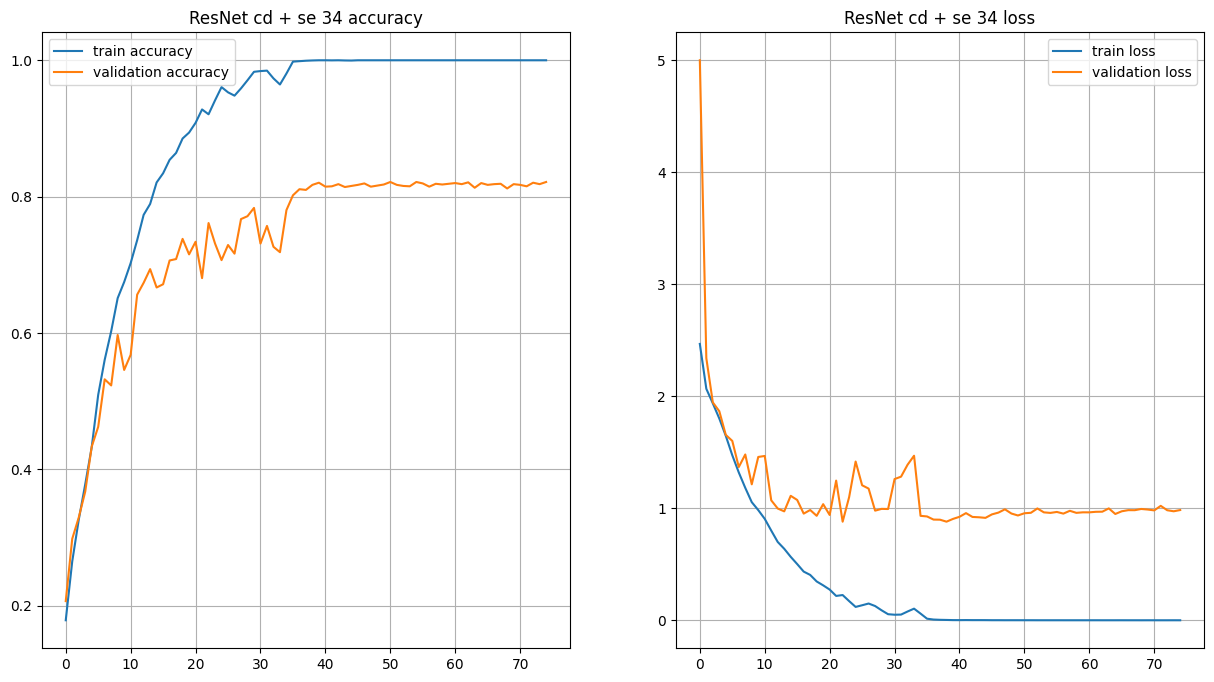

Validation accuracy: 0.822, best_val_acc: 0.822


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.14it/s, accuracy=0.804]


Test accuracy of ResNet cd + se 34 = 0.8035668789808917


In [27]:
resnet_cd_se_34 = DataParallel(
    resnet(num_layers=34,
           use_resnet_c = True,
           use_resnet_d = True,
           use_se = True).to(device), 
    device_ids=DEVICE_IDS
)
optimizer = Adam(resnet_cd_se_34.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5)
result_resnet_34_cd_se = train(
    resnet_cd_se_34, 
    train_dataloader, 
    val_dataloader,
    test_dataloader,
    optimizer, 
    criterion, 
    device,
    scheduler, 
    N_EPOCHS, 
    title='ResNet cd + se 34'
)

del resnet_cd_se_34

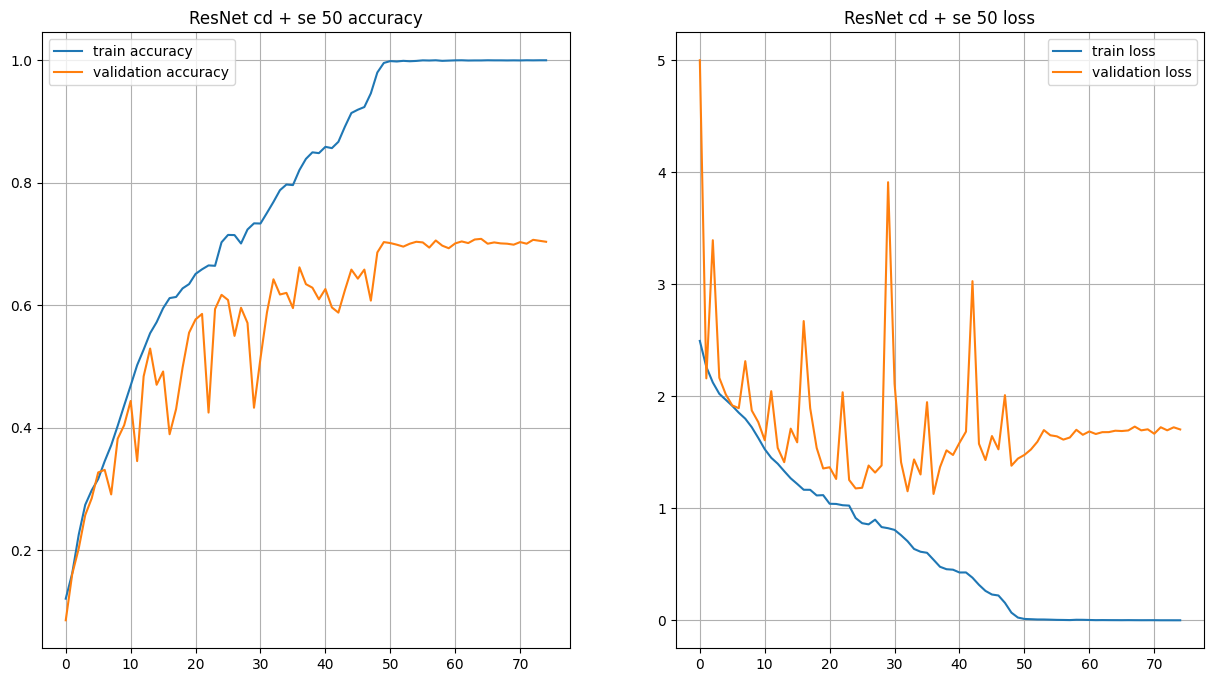

Validation accuracy: 0.704, best_val_acc: 0.709


Testing: 100%|██████████| 16/16 [00:05<00:00,  3.01it/s, accuracy=0.708]

Test accuracy of ResNet cd + se 50 = 0.70828025477707


In [29]:
resnet_cd_se_50 = DataParallel(
    resnet(num_layers=50,
           use_resnet_c = True,
           use_resnet_d = True,
           use_se = True).to(device), 
    device_ids=DEVICE_IDS
)
optimizer = Adam(resnet_cd_se_50.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5)
result_resnet_50_cd_se = train(
    resnet_cd_se_50, 
    train_dataloader, 
    val_dataloader,
    test_dataloader,
    optimizer, 
    criterion, 
    device,
    scheduler, 
    N_EPOCHS, 
    title='ResNet cd + se 50'
)

del resnet_cd_se_50

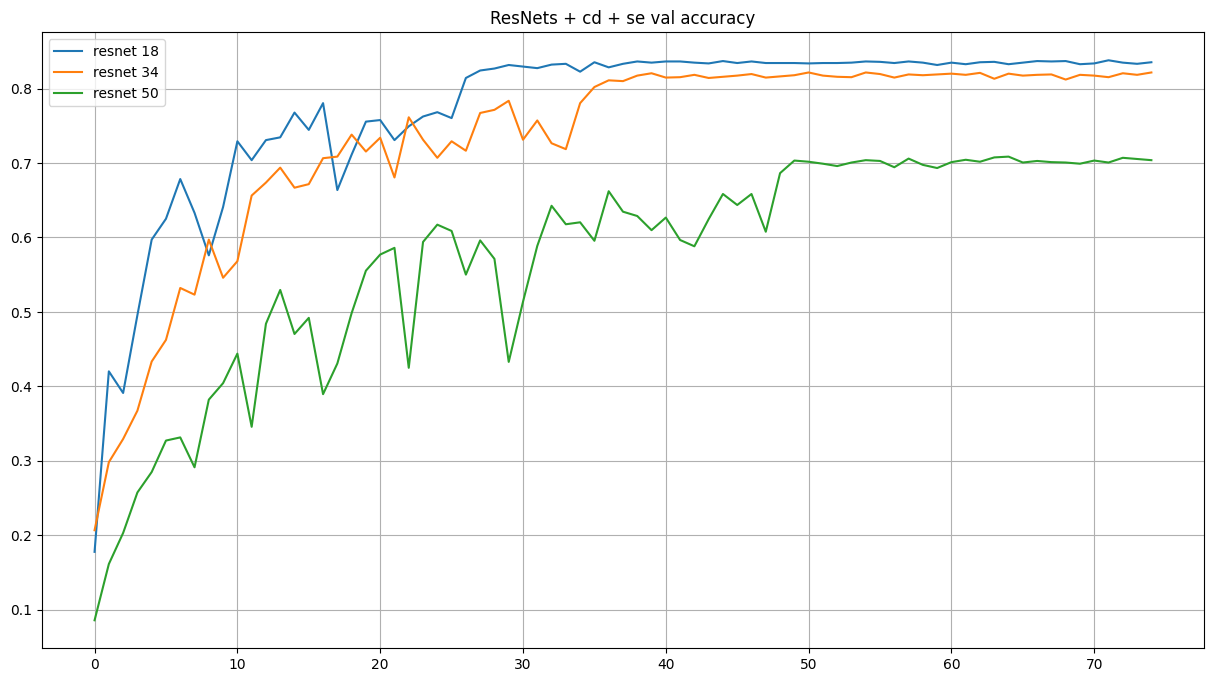

In [30]:
plt.plot(range(N_EPOCHS), result_resnet_18_cd_se['val_acc'], label='resnet 18')
plt.plot(range(N_EPOCHS), result_resnet_34_cd_se['val_acc'], label='resnet 34')
plt.plot(range(N_EPOCHS), result_resnet_50_cd_se['val_acc'], label='resnet 50')
plt.title(label='ResNets + cd + se val accuracy')
plt.grid()
plt.legend()
plt.show()

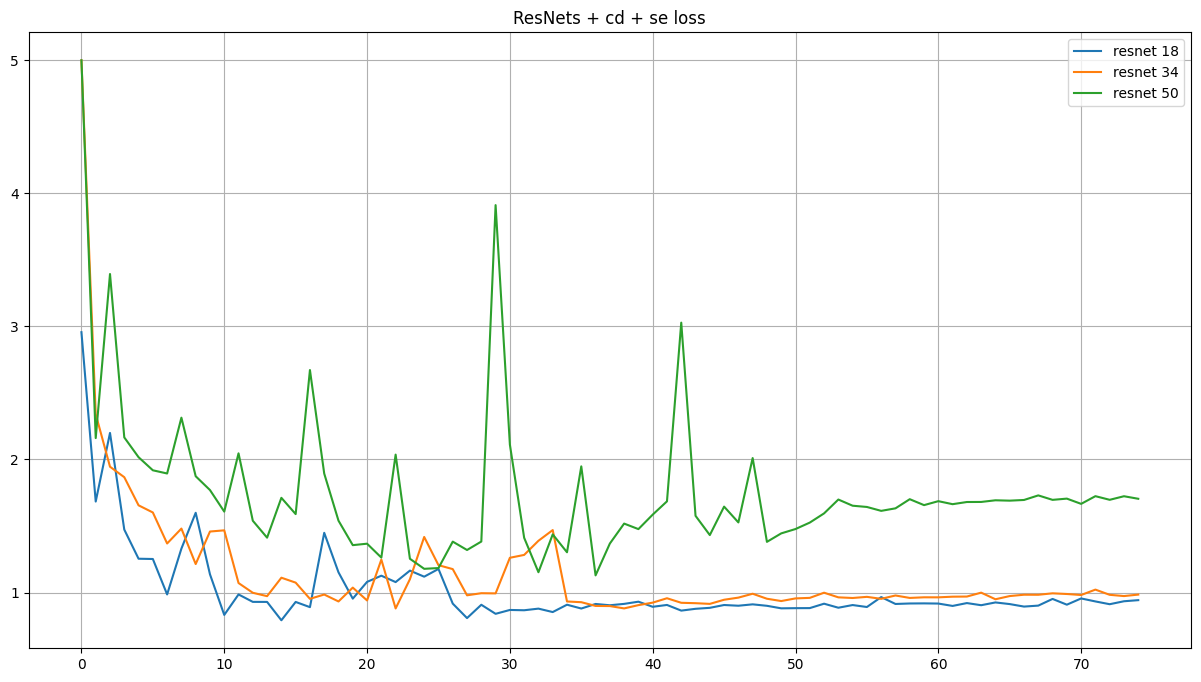

In [31]:
plt.plot(range(N_EPOCHS), result_resnet_18_cd_se['val_loss'], label='resnet 18')
plt.plot(range(N_EPOCHS), result_resnet_34_cd_se['val_loss'], label='resnet 34')
plt.plot(range(N_EPOCHS), result_resnet_50_cd_se['val_loss'], label='resnet 50')
plt.title(label='ResNets + cd + se loss')
plt.grid()
plt.legend()
plt.show()

In [32]:
test_acc_18 = result_resnet_18_cd_se['test_acc']
test_acc_34 = result_resnet_34_cd_se['test_acc']
test_acc_50 = result_resnet_50_cd_se['test_acc']
print(f'Test accuracies \nResNet 18: {test_acc_18} \
    \nResNet 34: {test_acc_34} \
    \nResNet 50: {test_acc_50}')

Test accuracies 
ResNet 18: 0.8407643312101911     
ResNet 34: 0.8035668789808917     
ResNet 50: 0.70828025477707


In [33]:
torch.save(result_resnet_18_cd_se['best_state'], 'resnet18+cd+se.pt')
torch.save(result_resnet_34_cd_se['best_state'], 'resnet34+cd+se.pt')
torch.save(result_resnet_50_cd_se['best_state'], 'resnet50+cd+se.pt')

## ResNext with everything

In [ ]:
BATCH_SIZE = 64
N_WORKERS = 16
LR = 5*1e-4

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)

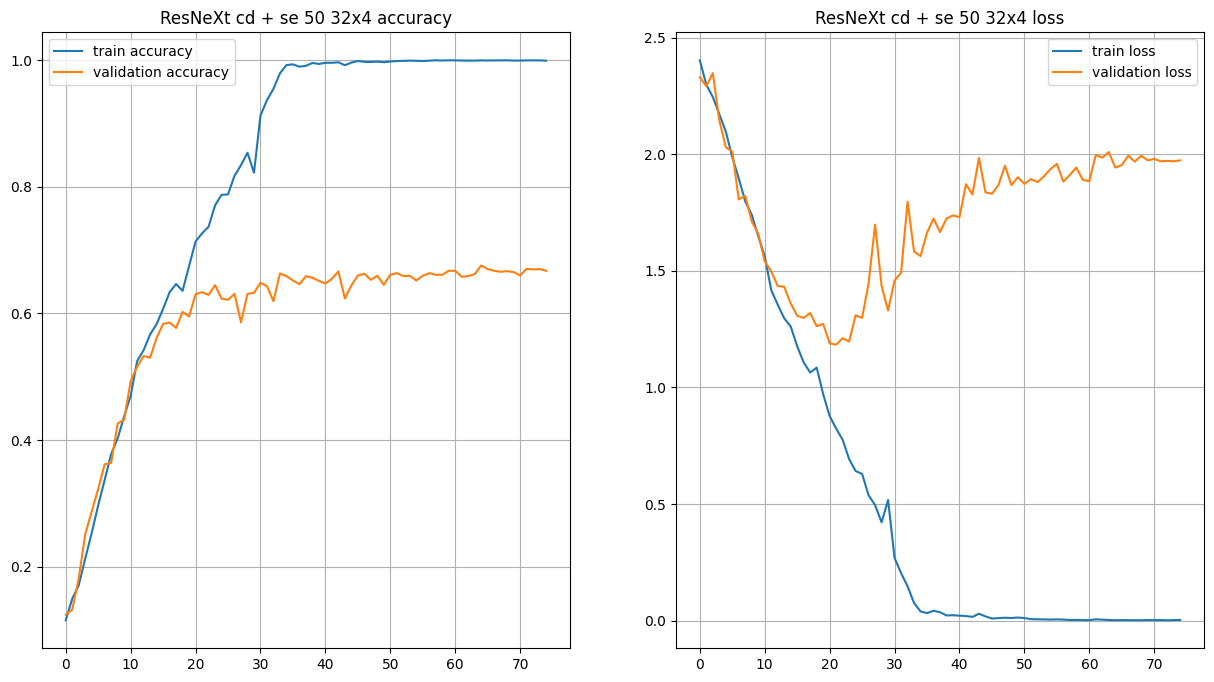

Validation accuracy: 0.667, best_val_acc: 0.676


Testing: 100%|██████████| 62/62 [00:09<00:00,  6.83it/s, accuracy=0.659]

Test accuracy of ResNeXt cd + se 50 32x4 = 0.6593630573248408


In [12]:
resnext_cd_se_50_32x4 = DataParallel(
    resnext(num_layers=50, 
           cardinality=32, 
           width=4,
           use_resnet_c = True,
           use_resnet_d = True,
           use_se = True).to(device), 
    device_ids=DEVICE_IDS
)
optimizer = Adam(resnext_cd_se_50_32x4.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5)
result_resnext_50_cd_se_32x4 = train(
    resnext_cd_se_50_32x4, 
    train_dataloader, 
    val_dataloader,
    test_dataloader,
    optimizer, 
    criterion, 
    device,
    scheduler, 
    N_EPOCHS, 
    title='ResNeXt cd + se 50 32x4'
)

del resnext_cd_se_50_32x4

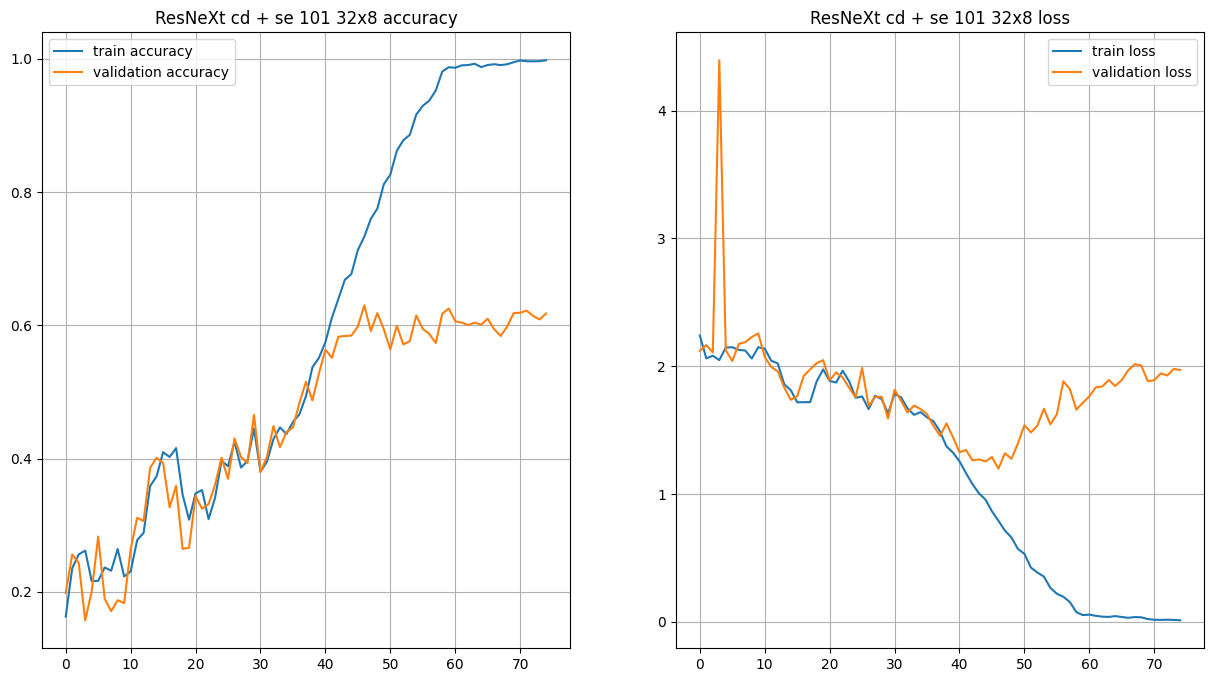

Validation accuracy: 0.618, best_val_acc: 0.630


Testing: 100%|██████████| 62/62 [00:15<00:00,  3.91it/s, accuracy=0.616]

Test accuracy of ResNeXt cd + se 101 32x8 = 0.6155414012738853


In [14]:
resnext_cd_se_101_32x8 = DataParallel(
    resnext(num_layers=101, 
           cardinality=32, 
           width=8,
           use_resnet_c = True,
           use_resnet_d = True,
           use_se = True).to(device), 
    device_ids=DEVICE_IDS
)
optimizer = Adam(resnext_cd_se_101_32x8.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5)
result_resnet_101_cd_se_32x8 = train(
    resnext_cd_se_101_32x8, 
    train_dataloader, 
    val_dataloader,
    test_dataloader,
    optimizer, 
    criterion, 
    device,
    scheduler, 
    N_EPOCHS, 
    title='ResNeXt cd + se 101 32x8'
)

del resnext_cd_se_101_32x8

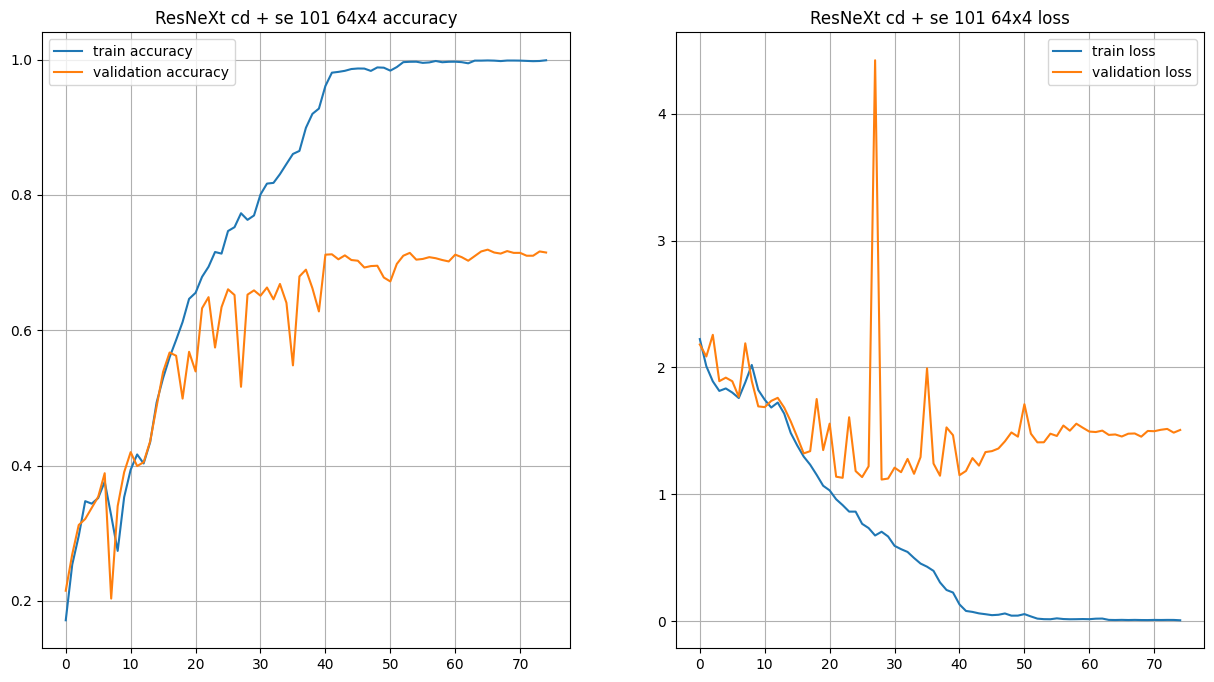

Validation accuracy: 0.715, best_val_acc: 0.719


Testing: 100%|██████████| 62/62 [00:15<00:00,  3.93it/s, accuracy=0.698]

Test accuracy of ResNeXt cd + se 101 64x4 = 0.698343949044586


In [15]:
resnext_cd_se_101_64x4 = DataParallel(
    resnext(num_layers=101, 
           cardinality=64, 
           width=4,
           use_resnet_c = True,
           use_resnet_d = True,
           use_se = True).to(device), 
    device_ids=DEVICE_IDS
)
optimizer = Adam(resnext_cd_se_101_64x4.parameters(), lr=LR)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5)
result_resnet_101_cd_se_64x4 = train(
    resnext_cd_se_101_64x4, 
    train_dataloader, 
    val_dataloader,
    test_dataloader,
    optimizer, 
    criterion, 
    device,
    scheduler, 
    N_EPOCHS, 
    title='ResNeXt cd + se 101 64x4'
)

del resnext_cd_se_101_64x4

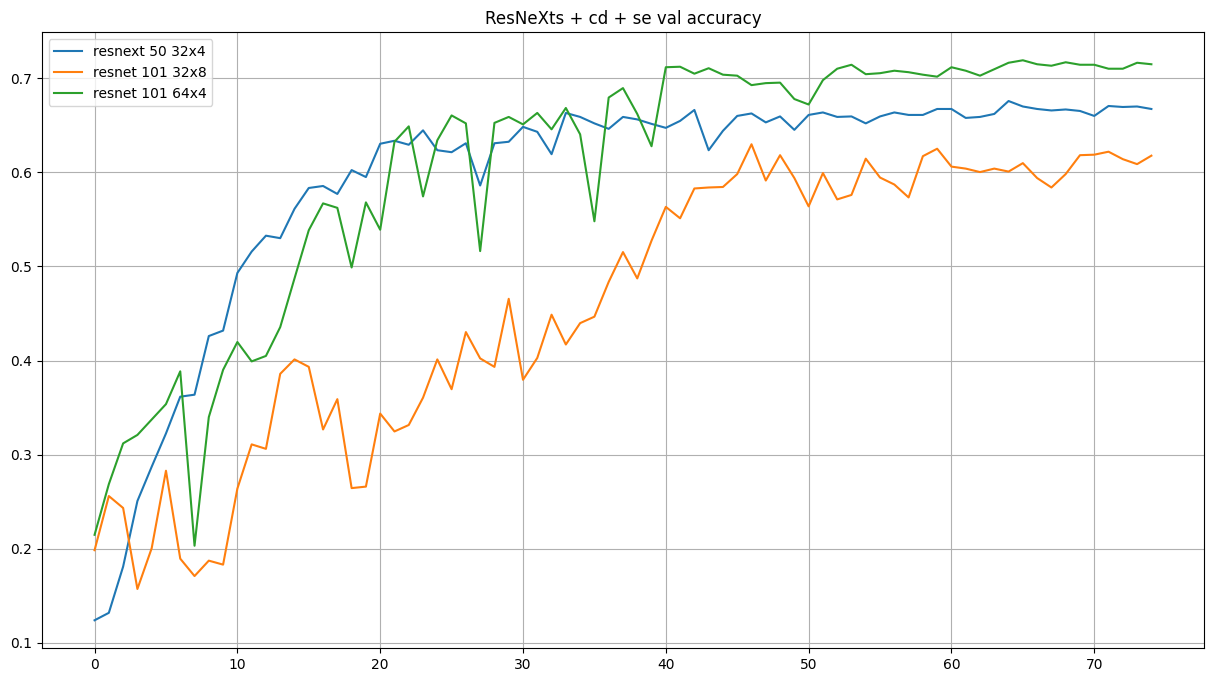

In [17]:
plt.plot(range(N_EPOCHS), result_resnext_50_cd_se_32x4['val_acc'], label='resnext 50 32x4')
plt.plot(range(N_EPOCHS), result_resnet_101_cd_se_32x8['val_acc'], label='resnet 101 32x8')
plt.plot(range(N_EPOCHS), result_resnet_101_cd_se_64x4['val_acc'], label='resnet 101 64x4')
plt.title(label='ResNeXts + cd + se val accuracy')
plt.grid()
plt.legend()
plt.show()

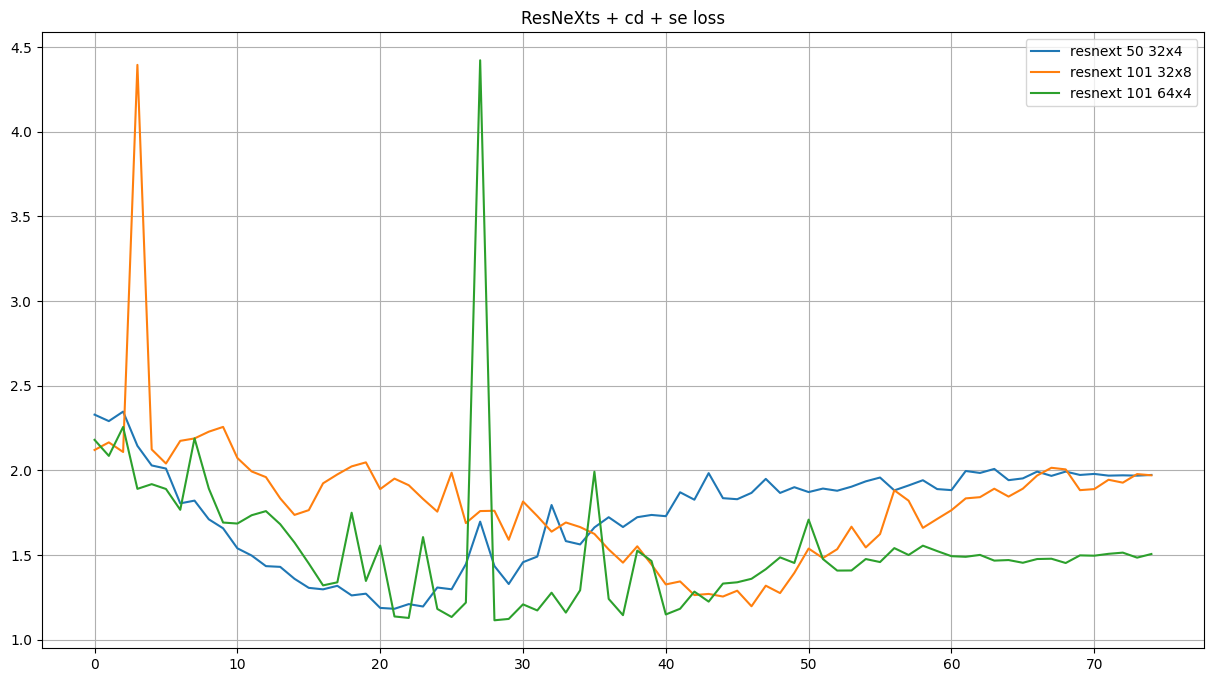

In [21]:
plt.plot(range(N_EPOCHS), result_resnext_50_cd_se_32x4['val_loss'], label='resnext 50 32x4')
plt.plot(range(N_EPOCHS), result_resnet_101_cd_se_32x8['val_loss'], label='resnext 101 32x8')
plt.plot(range(N_EPOCHS), result_resnet_101_cd_se_64x4['val_loss'], label='resnext 101 64x4')
plt.title(label='ResNeXts + cd + se loss')
plt.grid()
plt.legend()
plt.show()

In [23]:
test_acc_50_32x4 = result_resnext_50_cd_se_32x4['test_acc']
test_acc_101_32x8 = result_resnet_101_cd_se_32x8['test_acc']
test_acc_101_64x4 = result_resnet_101_cd_se_64x4['test_acc']
print(f'Test accuracies \nResNeXt 50 32x4: {test_acc_50_32x4} \
    \nResNeXt 101 32x8: {test_acc_101_32x8} \
    \nResNeXt 101 64x4: {test_acc_101_64x4}')

Test accuracies 
ResNeXt 50 32x4: 0.6593630573248408     
ResNeXt 101 32x8: 0.6155414012738853     
ResNeXt 101 64x4: 0.698343949044586


In [24]:
torch.save(result_resnext_50_cd_se_32x4['best_state'], 'resnext50_32x4.pt')
torch.save(result_resnet_101_cd_se_32x8['best_state'], 'resnext101_32x8.pt')
torch.save(result_resnet_101_cd_se_64x4['best_state'], 'resnext101_64x4.pt')